In [2]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style
set_style("whitegrid")

In [20]:
def powerset(s):
    power_set = [[]]
    for x in s:
        power_set += [s0+[x] for s0 in power_set]
    return power_set[1:]

In [3]:
df = pd.read_csv('F1Data.csv')

In [4]:
F1_master_test = df[df['Season'] >= 2021]
F1_2020 = df[df['Season'] <= 2020]
F1 = F1_2020[F1_2020['Qualifying Time'] > 30]

In [21]:
potential_features = ['FP1 Time', 'FP1 Gap', 'FP1 Laps',
                      'FP2 Time', 'FP2 Gap', 'FP2 Laps',
                      'FP3 Time', 'FP3 Gap', 'FP3 Laps']

all_models = ['baseline']
all_models.extend(powerset(potential_features))

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
F1_train, F1_test = train_test_split(F1, test_size = .2, random_state = 949, shuffle = True)

In [25]:
## import KFold, Linear Regression, and kNeighborsRegressor here
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

## import mean_squared_error
from sklearn.metrics import mean_squared_error

In [33]:
kfold = KFold(5, random_state = 818, shuffle = True)
mses = np.zeros((len(all_models), 5))

In [38]:
j = 0
for train_index, test_index in kfold.split(F1_train):
    F1_tt = F1_train.iloc[train_index]
    F1_ho = F1_train.iloc[test_index]
    
    i = 0
    for model in all_models:
        if model == "baseline":
            pred = F1_tt['Qualifying Time'].mean() * np.ones(len(F1_ho))
            mses[i, j] = mean_squared_error(F1_ho['Qualifying Time'], pred)
        else:
            if len(model) == 1:
                reg = LinearRegression()
                reg.fit(F1_tt[model].values.reshape(-1,1), F1_tt['Qualifying Time'])
                pred = reg.predict(F1_ho[model].values.reshape(-1,1))
                mses[i, j] = mean_squared_error(F1_ho['Qualifying Time'], pred)
            else:
                reg = LinearRegression()
                reg.fit(F1_tt[model].values, F1_tt['Qualifying Time'])
                pred = reg.predict(F1_ho[model].values)
                mses[i, j] = mean_squared_error(F1_ho['Qualifying Time'], pred)
        i = i + 1
    j = j + 1

In [39]:
mses

array([[155.53917559, 161.11390605, 146.40081396, 157.36452497,
        162.99920087],
       [ 26.47451776,  28.17773121,  23.73166091,  27.26186431,
         32.30293149],
       [146.69030596, 153.01979425, 141.62849844, 147.56392895,
        166.91732283],
       ...,
       [ 13.19445137,  14.79415374,  13.90538162,  13.46398158,
         15.26018226],
       [ 13.92068076,  15.21754404,  14.56128404,  13.71075204,
         15.91372817],
       [ 12.97607519,  14.55782475,  13.97311852,  13.17798263,
         14.99648017]])

In [44]:
np.min(np.mean(np.sqrt(mses), axis = 1))

3.7254825197592902

In [45]:
all_models[np.argmin(np.mean(np.sqrt(mses), axis=1))]

['FP1 Time', 'FP1 Gap', 'FP2 Gap', 'FP2 Laps', 'FP3 Time']

In [57]:
i = 0
mse = np.zeros((8, 5))
for train_index, test_index in kfold.split(F1_train):
    F1_tt = F1_train.iloc[train_index]
    F1_ho = F1_train.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model
    baseline_pred = F1_tt['Qualifying Time'].mean()*np.ones(len(F1_ho))
    
    mse[0, i] = mean_squared_error(F1_ho['Qualifying Time'], 
                                             baseline_pred)
    
    ## Model 1
    slr_1 = LinearRegression()
    slr_1.fit(F1_tt['FP2 Laps'].values.reshape(-1,1), F1_tt['Qualifying Time'])
    mse[1, i] = mean_squared_error(F1_ho['Qualifying Time'], 
                                             slr_1.predict(F1_ho['FP2 Laps'].values.reshape(-1,1)))
    
    ## Model 2
    slr_2 = LinearRegression()
    slr_2.fit(F1_tt['FP2 Gap'].values.reshape(-1,1), F1_tt['Qualifying Time'])
    mse[2, i] = mean_squared_error(F1_ho['Qualifying Time'], 
                                   slr_2.predict(F1_ho['FP2 Gap'].values.reshape(-1,1)))
    
    ## Model 3
    slr_3 = LinearRegression()
    slr_3.fit(F1_tt['FP2 Time'].values.reshape(-1,1), F1_tt['Qualifying Time'])
    mse[3, i] = mean_squared_error(F1_ho['Qualifying Time'], 
                                   slr_3.predict(F1_ho['FP2 Time'].values.reshape(-1,1)))
    
    ## Model 4
    slr_4 = LinearRegression()
    slr_4.fit(F1_tt[['FP1 Time', 'FP1 Laps']],
               F1_tt['Qualifying Time'])
    mse[4, i] = mean_squared_error(F1_ho['Qualifying Time'], 
                                   slr_4.predict(F1_ho[['FP1 Time', 'FP1 Laps']]))
    
    
    ## Model 5
    slr_5 = LinearRegression()
    slr_5.fit(F1_tt[['FP1 Time', 'FP1 Gap', 'FP2 Gap',
                     'FP2 Laps', 'FP3 Time']],
               F1_tt['Qualifying Time'])
    mse[5, i] = mean_squared_error(F1_ho['Qualifying Time'], 
                                   slr_5.predict(F1_ho[['FP1 Time', 'FP1 Gap', 'FP2 Gap',
                                                        'FP2 Laps', 'FP3 Time']]))
    
    ## Model 6
    knn_op = KNeighborsRegressor(10)
    
    knn_op.fit(F1_tt[['FP1 Time', 'FP1 Gap', 'FP2 Gap',
                   'FP2 Laps', 'FP3 Time']], 
            F1_tt['Qualifying Time'].values)
    
    mse[6, i] = mean_squared_error(F1_ho['Qualifying Time'], 
                                   knn_op.predict(F1_ho[['FP1 Time', 'FP1 Gap', 'FP2 Gap',
                                                         'FP2 Laps', 'FP3 Time']]))
    
    ## Model 7
    knn = KNeighborsRegressor(10)
    
    knn.fit(F1_tt[['FP1 Time', 'FP1 Gap', 'FP1 Laps',
                   'FP2 Time', 'FP2 Gap', 'FP2 Laps',
                   'FP3 Time', 'FP3 Gap', 'FP3 Laps']], 
            F1_tt['Qualifying Time'].values)
    
    mse[7, i] = mean_squared_error(F1_ho['Qualifying Time'], 
                                   knn.predict(F1_ho[['FP1 Time', 'FP1 Gap', 'FP1 Laps',
                                                      'FP2 Time', 'FP2 Gap', 'FP2 Laps',
                                                      'FP3 Time', 'FP3 Gap', 'FP3 Laps']]))
    
    
    
    i = i + 1

In [58]:
mse

array([[155.53917559, 161.11390605, 146.40081396, 157.36452497,
        162.99920087],
       [140.43588325, 148.26289963, 130.89130213, 152.78247508,
        153.26677226],
       [145.10612576, 151.55326747, 142.7812697 , 150.25242679,
        156.56144159],
       [ 39.41035341,  34.78324181,  25.94856554,  35.99808995,
         39.77195586],
       [ 25.92720065,  27.68306789,  23.62003984,  26.7331884 ,
         31.53583622],
       [ 13.0443496 ,  14.39239437,  13.94364071,  13.1262779 ,
         14.93703795],
       [ 10.41710346,  12.70888194,  11.83298864,  11.25057074,
         11.96400131],
       [  8.81862313,  12.10010296,  13.51655659,  11.36009166,
         11.0496126 ]])

In [12]:
# plt.figure(figsize=(7,5))

# plt.hist(cars_train.selling_price, bins=30)

# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)

# plt.ylabel("Count", fontsize=12)
# plt.xlabel("Selling Price", fontsize=12)

# plt.title("Histogram of Selling Price", fontsize=14)

# plt.show()

In [13]:
X = knn_.predict(F1_test[['FP2 Laps']])

Y = F1_test['Qualifying Time']

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [14]:
mean_squared_error(Y,X)

145.49776615243857

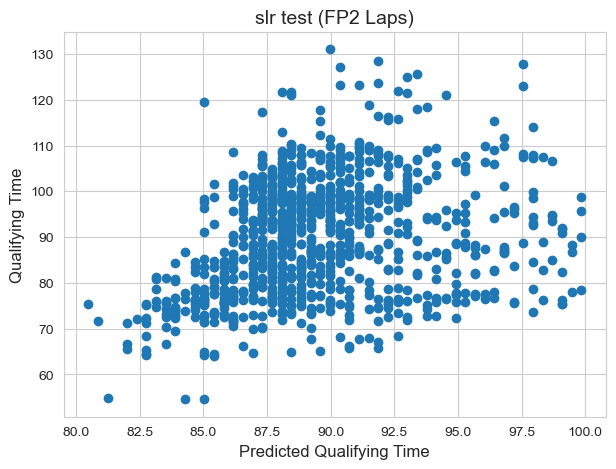

In [15]:
# X = knn.predict(F1_test[['FP1 Time', 'FP1 Gap', 'FP1 Laps',
#                                       'FP2 Time', 'FP2 Gap', 'FP2 Laps',
#                                       'FP3 Time', 'FP3 Gap', 'FP3 Laps']])
# Y = F1_test['Qualifying Time'].values

plt.figure(figsize=(7,5))

plt.scatter(X,Y)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.ylabel("Qualifying Time", fontsize=12)
plt.xlabel("Predicted Qualifying Time", fontsize=12)

plt.title("slr test (FP2 Laps)", fontsize=14)

plt.show()

In [16]:
X_main = slr_1.predict(F1_master_test[['FP2 Laps']])

Y_main = F1_master_test['Qualifying Time'].values

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [17]:
mean_squared_error(Y_main,X_main)

147.03200718036172

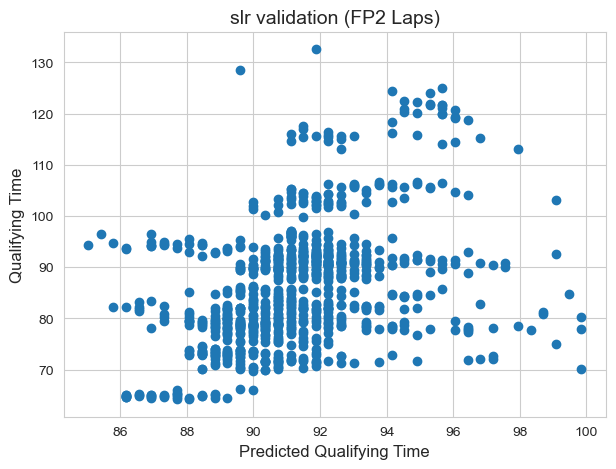

In [18]:
plt.figure(figsize=(7,5))

plt.scatter(X_main,Y_main)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.ylabel("Qualifying Time", fontsize=12)
plt.xlabel("Predicted Qualifying Time", fontsize=12)

plt.title("slr validation (FP2 Laps)", fontsize=14)

plt.show()

In [19]:
F1_train

,Season,Grand Prix,Driver,Constructor,FP1 Time,FP1 Gap,FP1 Laps,FP2 Time,FP2 Gap,FP2 Laps,FP3 Time,FP3 Gap,FP3 Laps,Grid Position,Qualifying Time
1613,2018,azerbaijan-grand-prix,Stroll,Williams,106.590,2.348,26.0,104.459,1.664,31.0,104.123,1.032,8.0,11.0,104.359
2997,2014,monaco-grand-prix,Pérez,Force India,79.666,1.395,29.0,79.668,1.186,9.0,77.725,0.967,23.0,10.0,78.108
5458,2008,chinese-grand-prix,Piquet,Renault,97.180,1.550,30.0,96.094,0.344,38.0,96.789,0.728,20.0,11.0,96.029
2209,2017,abu-dhabi-grand-prix,Massa,Williams,100.723,1.717,27.0,99.635,1.758,36.0,99.383,1.756,16.0,10.0,98.629
5601,2007,canadian-grand-prix,Schumacher,Toyota,78.652,0.893,32.0,79.331,2.781,16.0,77.748,1.677,13.0,18.0,77.634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5658,2007,british-grand-prix,Räikkönen,Ferrari,81.211,0.111,26.0,80.639,0.000,35.0,79.751,0.000,17.0,2.0,79.753
3314,2013,bahrain-grand-prix,Alonso,Ferrari,94.564,0.077,19.0,94.310,0.156,29.0,93.247,0.000,12.0,3.0,92.878
5961,2006,hungarian-grand-prix,Monteiro,Midland,87.321,5.697,8.0,84.508,2.730,8.0,83.819,3.024,12.0,16.0,82.009
1278,2019,monaco-grand-prix,Räikkönen,Alfa Romeo,73.363,1.257,39.0,72.342,1.224,51.0,72.308,1.043,27.0,14.0,71.993
